# Various Tests of opt-SNE on flow data

We will investigate: 
- 1NN accuracy and KLD values of embeddings 
- across "bh" vs "fft" 
- random vs pca init 
- embeddings with or without opt-SNE automated stopping 

## Utils

### Data Preprocessing

In [39]:
%matplotlib inline

# imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import flowkit as fk 
from openTSNE import TSNE
import openTSNE

# Pre-processing data 
sample = fk.Sample('data/flow18_annotated.fcs', sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")

# only use selected columns 
selected_columns = [
    'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'Parameter_8', 'Parameter_9', 'class'
]

df_filtered = df_events[selected_columns]

### KLD Monitoring

In [40]:
from openTSNE import callbacks
buffer_ee = 15
switch_buffer = 2 

class KLDRCMonitorEE(callbacks.Callback):
    def __init__(self, record_every=3):
        """
        Parameters:
            record_every (int): Check KL divergence every this many iterations.
            buffer_ee (int): Minimum iterations before monitoring KL divergence.
            switch_buffer (int): Extra iterations to confirm EE phase exit.
        """
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_ee = 3`
        
        self.kl_divergences = []
        self.last_error = None
        self.last_rel_change = None
        self.switch_buffer_count = switch_buffer  # Tracks remaining iterations before exiting EE

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence and determines when to stop Early Exaggeration.
        Returns True if EE should stop.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

            if self.last_error is not None:
                # Compute relative change: (prev_error - current_error) / prev_error
                rel_change = 100 * (self.last_error - error) / self.last_error  

                print(f"Iteration {iteration}: KL Divergence = {error:.4f}, Relative Change = {rel_change:.4f}%")

                # Start checking only after `buffer_ee` iterations
                if iteration > buffer_ee:
                    if self.last_rel_change is not None and rel_change < self.last_rel_change:
                        # If relative change decreases, start the switch buffer countdown
                        if self.switch_buffer_count < 1:
                            print("Relative change has consistently decreased. Stopping Early Exaggeration.")
                            print(f"EE Iteration stopped at {iteration}")
                            return True  # Signal to stop EE phase
                        self.switch_buffer_count -= 1
                    else:
                        # Reset switch buffer if relative change increases again
                        self.switch_buffer_count = switch_buffer

                self.last_rel_change = rel_change

            # Update last error for the next iteration
            self.last_error = error

        EE_iteration_stopped = iteration 
        return False  # Continue EE phase if conditions are not met


In [41]:
class KLDRCMonitorNoOpt(callbacks.Callback):
    def __init__(self, record_every=5):
     
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_ee = 3`
        self.kl_divergences = []

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence. 
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

In [42]:
buffer_run = 150 
auto_iter_end = 100 

class KLDRCMonitorRun(callbacks.Callback):
    def __init__(self, record_every=5):
        """
        Parameters:
            record_every (int): Check KL divergence every this many iterations.
            buffer_run (int): Minimum iterations after EE before monitoring for stopping.
            auto_iter_end (float): Threshold for stopping, lower values stop earlier.
        """
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_run = 5`
        # self.buffer_run = buffer_run  # Equivalent to `auto_iter_buffer_run = 15`
        # self.auto_iter_end = auto_iter_end  # Used for stopping condition

        self.kl_divergences = []
        self.last_error = None

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence and determines when to stop the full t-SNE run.
        Returns True if the run should stop.
        """
        # Only check KL divergence every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

            if self.last_error is not None:
                # Compute absolute error difference
                error_diff = abs(self.last_error - error)

                print(f"Iteration {iteration}: KL Divergence = {error:.4f}, Error Diff = {error_diff:.6f}")

                # Start monitoring only after `buffer_run` iterations have passed
                if iteration > buffer_run:
                    # Stopping condition from C++: abs(error_diff)/pollrate < error/auto_iter_end
                    if (error_diff / self.record_every) < (error / auto_iter_end):
                        print("KL divergence change is below threshold. Stopping optimization.")
                        print(f"Run iteration stopped at {iteration}")
                        return True  # Signal to stop t-SNE run

            # Update last error
            self.last_error = error

        return False  # Continue t-SNE run


### 1NN Accuracy

In [43]:
from sklearn.neighbors import NearestNeighbors

def compute_1nn_accuracy(Y, labels):
    """
    Computes the 1-Nearest Neighbor (1NN) accuracy of the t-SNE embedding.

    Parameters:
    - Y (numpy array): t-SNE embedding of shape (N, no_dims)
    - labels (numpy array): Ground truth labels of shape (N,)

    Returns:
    - accuracy (float): 1NN classification accuracy
    """
    N = Y.shape[0]  # Number of data points

    # Use Nearest Neighbors to find the closest point
    nn = NearestNeighbors(n_neighbors=2, metric='euclidean')  # Find 2 nearest (1st is itself)
    nn.fit(Y)
    distances, indices = nn.kneighbors(Y)  # Get nearest neighbor indices
    labels = np.array(labels)

    # The 1NN prediction is the label of the nearest neighbor (not itself)
    nearest_neighbor_indices = indices[:, 1]  # Take the second closest (first is itself)
    predicted_labels = labels[nearest_neighbor_indices]

    # Compute accuracy
    accuracy = np.mean(predicted_labels == labels)  # Check how many match

    return accuracy

# Example Usage
# Y: Your t-SNE embedding of shape (N, 2) or (N, 3)
# labels: Ground truth labels of shape (N,)
# accuracy = compute_1nn_accuracy(Y, labels)
# print(f"1NN Accuracy: {accuracy * 100:.2f}%")

### Plotting

In [44]:
def plot_embedding(embedding, labels, data_percentage, neg_grad_method, init, learning_rate):     
    plt.figure(figsize=(6, 6))
    plt.scatter(
        embedding[:, 0], 
        embedding[:, 1], 
        c=labels, 
        cmap=plt.colormaps.get_cmap('Paired'), 
        s=10, 
        alpha=0.4
    )
    plt.title(f"opt-SNE on flow18, {100*data_percentage}% of dataset, {neg_grad_method}, {init} initialization, {learning_rate} learning rate")
    plt.show()

In [45]:
def compare_plots(embedding1, labels1, text1, 
                    embedding2, labels2, text2):  
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create side-by-side subplots

    # Plot first embedding
    axes[0].scatter(
        embedding1[:, 0], 
        embedding1[:, 1], 
        c=labels1, 
        cmap=plt.colormaps.get_cmap('Paired'), 
        s=10, 
        alpha=0.4
    )
    axes[0].set_title(f"opt-SNE on flow18 {text1}")

    # Plot second embedding
    axes[1].scatter(
        embedding2[:, 0], 
        embedding2[:, 1], 
        c=labels2, 
        cmap=plt.colormaps.get_cmap('Paired'), 
        s=10, 
        alpha=0.4
    )
    axes[1].set_title(f"opt-SNE on flow18 {text2}")

    plt.show()

### KLD 1NN Comparison

In [46]:
def plot_kld_1nn_comparison(kld1, acc1, text1,
                            kld2, acc2, text2):
    """
    Plots a compact line comparison of KL Divergence and 1NN Accuracy for two different embeddings.
    Ensures both y-axes start at 0 for fair visual comparison.
    """

    fig, ax1 = plt.subplots(figsize=(4, 6))  # Smaller plot size

    # X positions for the two embeddings
    indices = np.array([0, 1])

    # Plot KL Divergence on the first y-axis
    line1, = ax1.plot(indices, [kld1, kld2], 'bo-', label='KL Divergence')  
    ax1.set_ylabel("KL Divergence", fontsize=12, color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(0, max(kld1, kld2) * 1.1)  # Start at 0

    # Second y-axis for 1NN Accuracy
    ax2 = ax1.twinx()
    line2, = ax2.plot(indices, [acc1, acc2], 'ro-', label='1NN Accuracy')  
    ax2.set_ylabel("1NN Accuracy", fontsize=12, color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0, max(acc1, acc2) * 1.1)  # Start at 0

    # Set x-axis labels
    ax1.set_xticks(indices)
    ax1.set_xticklabels([text1, text2], rotation=15, ha="right", fontsize=10)

    # Title & legend (combine both y-axes)
    plt.title("KL Divergence & 1NN Accuracy", fontsize=12)
    ax1.legend([line1, line2], ["KL Divergence", "1NN Accuracy"], loc="best")

    plt.show()


### Running t-SNE

In [47]:
# this runs opt-SNE with FIt-SNE algorithm 
def run_optSNE(neg_grad_method="fft", init="pca", data_percentage=1.0, EE_factor=12, perplexity=50, learning_rate="auto", random_state=12, auto_stop=True): 
    """
        Parameters:
            neg_grad_method (string): Either "bh" for Barnes-Hut or "fft" for FIt-SNE.
            init (string): Either "pca" or "random" 
    """
    
    data_sample = df_filtered.sample(frac=data_percentage).reset_index(drop=True)

    # get features and labels 
    features = data_sample.drop(columns=['class'])  # All columns except 'class'
    labels = data_sample['class']  # Only the 'class' column

    affinites = openTSNE.affinity.PerplexityBasedNN(
    features.to_numpy(),
    perplexity=perplexity, 
    n_jobs=-1,
    random_state=random_state,
    verbose=True
    )

    initiali = openTSNE.initialization.random(n_samples=len(features) ,random_state=12, verbose=True) if init=="random" else openTSNE.initialization.pca(features.to_numpy(), random_state=random_state)


    # step 3: construct TSNEEmbedding object 
    embedding = openTSNE.TSNEEmbedding(
        initiali, 
        affinites, 
        negative_gradient_method=neg_grad_method, 
        random_state=random_state,
        verbose=True
    )

    kld_monitor_EE = KLDRCMonitorEE(record_every=3)
    kld_monitor_EE_noOpt = KLDRCMonitorNoOpt(record_every=3)
    if auto_stop: 
        try:
            embedding = embedding.optimize(
                n_iter=3000, 
                learning_rate=len(features)/EE_factor if learning_rate=="auto" else learning_rate, 
                exaggeration=EE_factor, 
                momentum=0.5, 
                callbacks=kld_monitor_EE, 
                callbacks_every_iters=3, 
                verbose=True
            )
        except Exception as e:
            # OptimizationInterrupt is expected when stopping early.
            print("Early Exaggeration phase stopped early:", e)
    else: 
        embedding = embedding.optimize(
                n_iter=int(2000/4), 
                learning_rate=len(features)/EE_factor if learning_rate=="auto" else learning_rate, 
                exaggeration=EE_factor, 
                momentum=0.5, 
                callbacks=kld_monitor_EE_noOpt, 
                callbacks_every_iters=3, 
                verbose=True
            )
  
    kld_tracker_embed = KLDRCMonitorRun(record_every=5)
    kld_monitor_noOpt = KLDRCMonitorNoOpt(record_every=5)
    if auto_stop: 
        try:
            embedding = embedding.optimize(
                n_iter=10000, 
                learning_rate=len(features)/EE_factor if learning_rate=="auto" else learning_rate, 
                momentum=0.8, 
                callbacks=kld_tracker_embed, 
                callbacks_every_iters=5, 
                verbose=True
            )
        except Exception as e:
            # OptimizationInterrupt is expected when stopping early.
            print("Embedding phase stopped early:", e)
    else: 
        embedding = embedding.optimize(
            n_iter=int(2000/4*3), 
            learning_rate=len(features)/EE_factor if learning_rate=="auto" else learning_rate, 
            momentum=0.8, 
            callbacks=kld_monitor_noOpt, 
            callbacks_every_iters=5, 
            verbose=True
        )

    # plot_embedding(data_percentage, neg_grad_method,init, learning_rate)
    final_kld =  kld_tracker_embed.kl_divergences[-1][1] if auto_stop else kld_monitor_noOpt.kl_divergences[-1][1]
    return (embedding, final_kld, labels) 


## Experiments

### PCA vs Random Init

In [ ]:
# note: this uses opt-SNE
embedding_rand, kld_rand, labels_rand = run_optSNE(init="random")
embedding_pca, kld_pca, labels_pca = run_optSNE(init="pca")

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...


In [ ]:
acc_rand = compute_1nn_accuracy(embedding_rand, labels_rand)
acc_pca = compute_1nn_accuracy(embedding_pca, labels_pca)

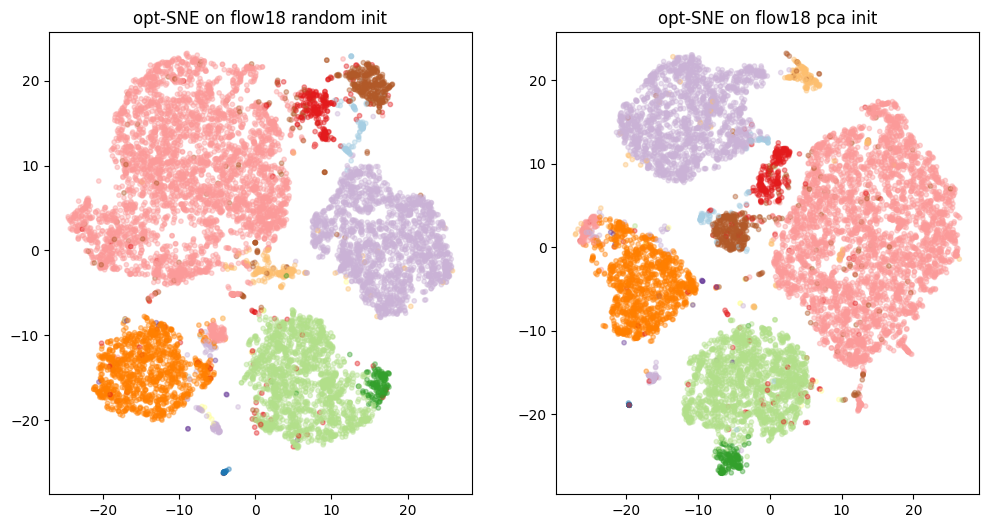

In [ ]:
compare_plots(
    embedding_rand, labels_rand, "random init", 
    embedding_pca, labels_pca, "pca init"
)

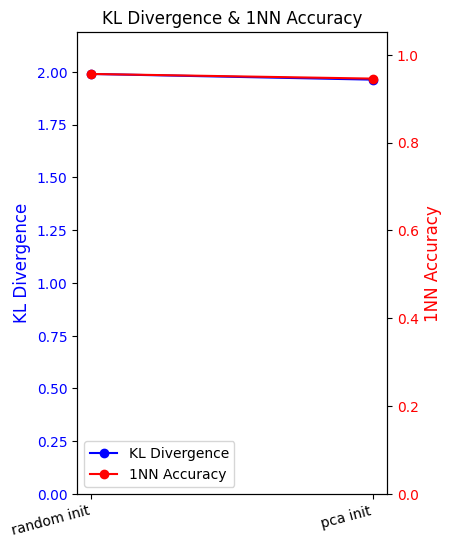

In [ ]:
plot_kld_1nn_comparison(kld_rand, acc_rand, "random init", kld_pca, acc_pca, "pca init")

### With and Without opt-SNE 

In [ ]:
embedding_auto, kld_auto, labels_auto = run_optSNE(auto_stop=True)
embedding_normal, kld_normal, labels_normal = run_optSNE(auto_stop=False)

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 12.31 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.66 seconds
===> Running optimization with exaggeration=12.00, lr=833.33 for 3000 iterations...
Iteration 6: KL Divergence = 5.1331, Relative Change = 0.0000%
Iteration 9: KL Divergence = 5.1331, Relative Change = 0.0000%
Iteration 12: KL Divergence = 5.1331, Relative Change = 0.0001%
Iteration 15: KL Divergence = 5.1330, Relative Change = 0.0008%
Iteration 18: KL Divergence = 5.1327, Relative Change = 0.0063%
Iteration 21: KL Divergence = 5.1305, Relative Change = 0.0423%
Iteration 24: KL Divergence = 5.1176, Relative Change = 0.2513%
Iteration 27: KL Divergence = 5.0467, Relative Change = 1.3859%
Iteration 30: KL Divergence = 4.8290, Relative Change = 4.3143%
Iteration 33: KL Divergence = 4.5952, Relative Change = 4.8415%
Iteration 36: KL Divergence = 4.4487, Relative Change = 3.1882%
Iteration 39: K

In [ ]:
acc_auto = compute_1nn_accuracy(embedding_auto, labels_auto)
acc_normal = compute_1nn_accuracy(embedding_normal, labels_normal)

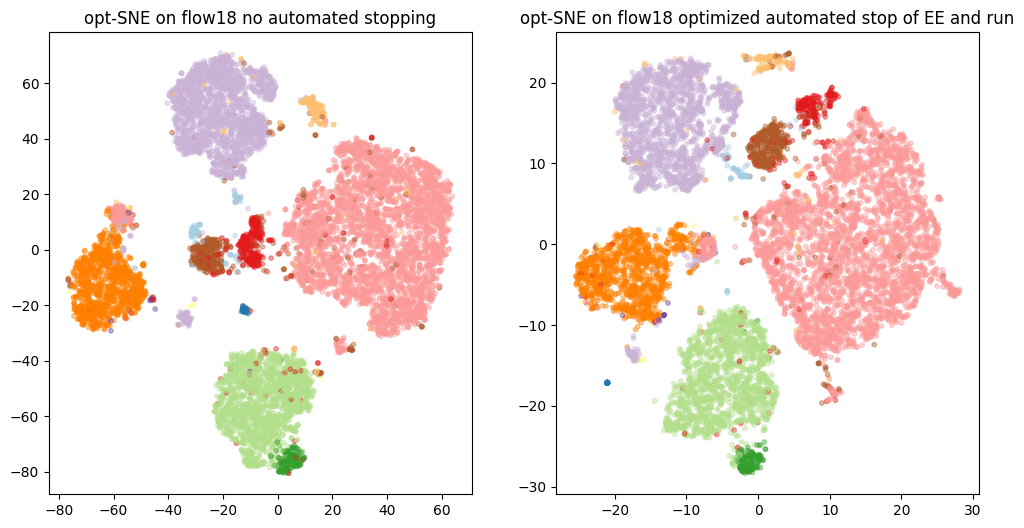

In [ ]:
compare_plots(
    embedding_normal, labels_normal, "no automated stopping", 
    embedding_auto, labels_auto, "optimized automated stop of EE and run"
)

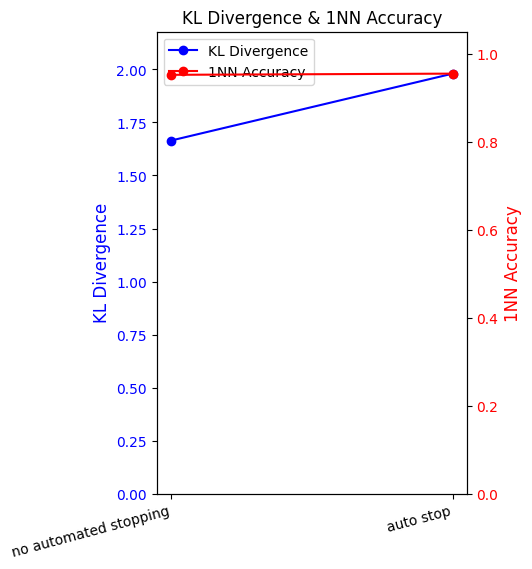

In [ ]:
plot_kld_1nn_comparison(kld_normal, acc_normal, "no automated stopping", kld_auto, acc_auto, "auto stop")

### Barnes-Hut vs FIt-SNE

In [ ]:
embedding_fft, kld_fft, labels_fft = run_optSNE(neg_grad_method="fft")
embedding_bh, kld_bh, labels_bh = run_optSNE(neg_grad_method="bh")

In [ ]:
acc_bh = compute_1nn_accuracy(embedding_bh, labels_bh)
acc_fft = compute_1nn_accuracy(embedding_fft, labels_fft)

In [ ]:
compare_plots(
    embedding_bh, labels_bh, "Barnes-Hut t-SNE", 
    embedding_fft, labels_fft, "FIt-SNE"
)

In [ ]:
plot_kld_1nn_comparison(kld_bh, acc_bh, "Barnes-Hut t-SNE", kld_fft, acc_fft, "FIt-SNE")